# Blood Vessel Segmentation from Fundus Images

## Introduction

This notebook implements a blood vessel segmentation algorithm for fundus images from the DIARETDB1 database. The goal is to isolate and highlight the blood vessels in retinal images using image processing techniques and morphological operations.

The algorithm follows two main stages:
1. **Preprocessing**: Enhancing image features and reducing noise
2. **Segmentation**: Producing a grayscale image that highlights the blood vessels

The implementation uses only standard image processing methods from libraries such as OpenCV and NumPy, with an emphasis on morphological operations.

## Development

### Libraries and Dependencies

First, we import the necessary libraries for image processing and file handling:

In [1]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Configure matplotlib for displaying images
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

# Check OpenCV version
print(f"OpenCV Version: {cv2.__version__}")

OpenCV Version: 4.10.0


### Setup Directory Structure

Next, we'll set up the input and output directories:

In [2]:
# Define base directory using environment variables
BASE_DIR = os.path.join(os.environ['USERPROFILE'], 'Documents', 'digital_image_processing')
INPUT_DIR = os.path.join(BASE_DIR, "P6A_Segmentation", "Input_Images")
OUTPUT_DIR = os.path.join(BASE_DIR, "P6A_Segmentation", "Output_Images")

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created output directory: {OUTPUT_DIR}")
else:
    print(f"Output directory already exists: {OUTPUT_DIR}")

# Create input directory if it doesn't exist
if not os.path.exists(INPUT_DIR):
    os.makedirs(INPUT_DIR)
    print(f"Created input directory: {INPUT_DIR}")
    print("Please add your images to the Input_Images folder")
else:
    image_files = [f for f in os.listdir(INPUT_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]
    print(f"Found {len(image_files)} image files in the input directory")

Output directory already exists: C:\Users\bglobalit\Documents\digital_image_processing\P6A_Segmentation\Output_Images
Found 89 image files in the input directory


### Helper Functions for Image Display

Let's define some utility functions to help display and compare images:

In [3]:
def display_image(image, title="Image", cmap=None):
    """Display a single image with title"""
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_multiple(images, titles=None, cmap=None, rows=1):
    """Display multiple images side by side"""
    n = len(images)
    if titles is None:
        titles = ['Image (%d)' % i for i in range(1, n + 1)]
    fig, axes = plt.subplots(rows, n // rows + (1 if n % rows else 0), figsize=(15, 5 * rows))
    if n == 1:
        axes = [axes]
    elif rows > 1:
        axes = axes.flat
    
    for i, (image, title) in enumerate(zip(images, titles)):
        if i < len(axes):
            if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale
                axes[i].imshow(image, cmap=cmap or 'gray')
            else:  # Color (BGR to RGB for display)
                if image.shape[2] == 3:  # Check if it has 3 channels
                    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                else:
                    axes[i].imshow(image)
            axes[i].set_title(title)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## Algorithm

Now, let's implement the blood vessel segmentation algorithm. The algorithm consists of two main stages:

1. **Preprocessing**: Enhance the image and reduce noise
2. **Segmentation**: Extract the blood vessels and highlight them

### Preprocessing Functions

First, let's define the preprocessing functions:

In [4]:
def preprocess_fundus_image(image):
    """Preprocess the fundus image to enhance vessel features and reduce noise"""
    # Convert to grayscale if not already
    if len(image.shape) > 2:
        # Extract the green channel which provides best vessel contrast in fundus images
        green_channel = image[:, :, 1]
    else:
        green_channel = image.copy()
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(green_channel)
    
    # Remove noise using Gaussian blur
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
    # Apply morphological operations to enhance vessel structures
    # Create a structuring element for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Top-hat transform to enhance bright objects against dark background
    tophat_image = cv2.morphologyEx(blurred_image, cv2.MORPH_TOPHAT, kernel)
    
    # Apply sharpening to enhance edges
    enhanced_image = cv2.addWeighted(clahe_image, 1.5, tophat_image, 0.5, 0)
    
    return enhanced_image

### Segmentation Functions

Now, let's implement the vessel segmentation function:

In [5]:
def segment_vessels(preprocessed_image):
    """Segment the blood vessels from the preprocessed image"""
    # Apply Frangi filter to enhance vessels (a vessel enhancement filter)
    # Since Frangi filter isn't directly in OpenCV, we'll simulate it with edge detection and morphology
    
    # Apply edge detection using Sobel operator
    sobelx = cv2.Sobel(preprocessed_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(preprocessed_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the magnitude of gradient
    magnitude = cv2.magnitude(sobelx, sobely)
    
    # Normalize to 0-255 range
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Apply adaptive thresholding to get vessel candidates
    # We're keeping it grayscale rather than binary as per requirements
    vessel_candidates = cv2.adaptiveThreshold(
        preprocessed_image, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        11, 
        2
    )
    
    # Combine the edge information with the vessel candidates
    segmented = cv2.bitwise_and(magnitude, vessel_candidates)
    
    # Apply morphological operations to clean up the segmentation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    segmented = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, kernel)
    
    # Apply a small amount of Gaussian blur to smooth the result
    segmented = cv2.GaussianBlur(segmented, (3, 3), 0)
    
    return segmented

### Alternative Segmentation Method

Let's also implement an alternative segmentation method using a different approach:

In [6]:
def segment_vessels_alternative(preprocessed_image):
    """Alternative method for vessel segmentation using morphological operations"""
    # Create structuring elements of different sizes
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Apply black-hat transform to extract dark vessels
    blackhat = cv2.morphologyEx(preprocessed_image, cv2.MORPH_BLACKHAT, kernel_medium)
    
    # Apply adaptive thresholding to enhance vessels
    thresh = cv2.adaptiveThreshold(
        blackhat, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 
        2
    )
    
    # Apply opening to remove small noise
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small)
    
    # Apply dilation to slightly thicken the vessels
    dilated = cv2.dilate(opening, kernel_small, iterations=1)
    
    # Combine the original preprocessed image with the vessel mask
    segmented = cv2.addWeighted(preprocessed_image, 0.7, dilated, 0.3, 0)
    
    # Apply a small amount of Gaussian blur to smooth the result
    segmented = cv2.GaussianBlur(segmented, (3, 3), 0)
    
    return segmented

### Complete Pipeline Function

Now, let's create a full pipeline function that processes a single image through all the steps:

In [7]:
def process_image(image_path, method="standard"):
    """Process a single fundus image and return intermediate and final results"""
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None, None, None
    
    # Preprocess the image
    preprocessed = preprocess_fundus_image(image)
    
    # Segment the vessels
    if method == "standard":
        segmented = segment_vessels(preprocessed)
    else:  # alternative method
        segmented = segment_vessels_alternative(preprocessed)
    
    return image, preprocessed, segmented

### Batch Processing Function

Finally, let's implement a function to process all images in the input directory:

In [8]:
def process_all_images(input_dir=INPUT_DIR, output_dir=OUTPUT_DIR, method="standard"):
    """Process all images in the input directory and save results to the output directory"""
    # Get list of image files
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]
    
    if not image_files:
        print("No image files found in the input directory")
        return
    
    # Process each image
    for image_file in image_files:
        image_path = os.path.join(input_dir, image_file)
        print(f"Processing {image_file}...")
        
        # Process the image
        original, preprocessed, segmented = process_image(image_path, method)
        
        if original is None:
            continue
        
        # Save the results
        base_name = os.path.splitext(image_file)[0]
        
        # Save preprocessed image
        preprocessed_path = os.path.join(output_dir, f"{base_name}_preprocessed.png")
        cv2.imwrite(preprocessed_path, preprocessed)
        
        # Save segmented image
        segmented_path = os.path.join(output_dir, f"{base_name}_segmented.png")
        cv2.imwrite(segmented_path, segmented)
        
        print(f"Saved results for {image_file}")
        
    print(f"Processed {len(image_files)} images")

## Results

Now, let's process a sample image to demonstrate the algorithm:

Processing sample image: image001.png


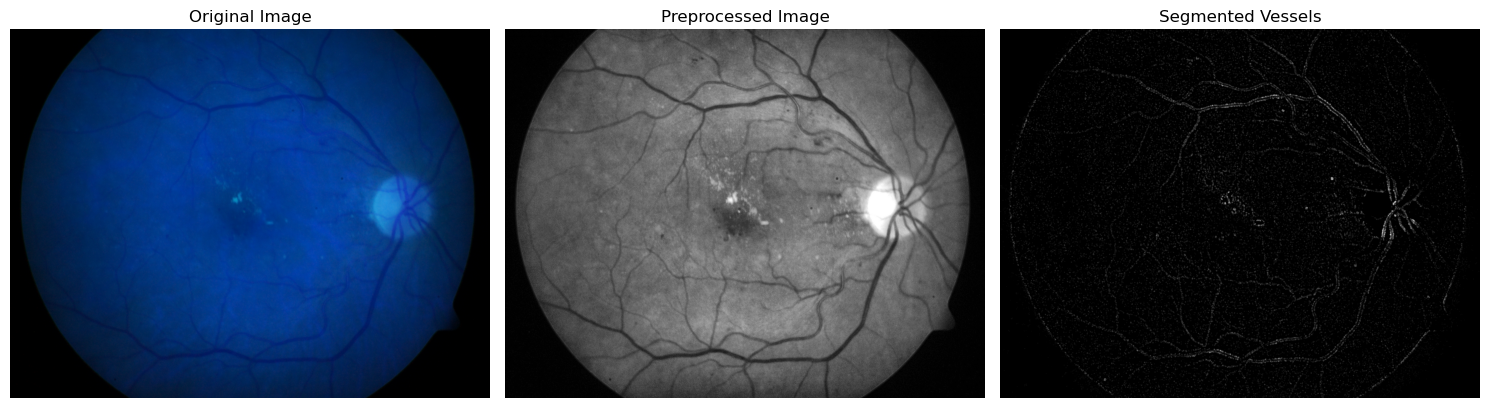

In [9]:
# Check if there are any images in the input directory
image_files = [f for f in os.listdir(INPUT_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]

if not image_files:
    print("No image files found in the input directory. Please add some images to the Input_Images folder.")
else:
    # Process the first image as an example
    sample_image_path = os.path.join(INPUT_DIR, image_files[0])
    print(f"Processing sample image: {image_files[0]}")
    
    # Process using the standard method
    original, preprocessed, segmented = process_image(sample_image_path, method="standard")
    
    # Display the results
    if original is not None:
        # Convert original from BGR to RGB for display
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # Display the original, preprocessed, and segmented images
        display_multiple(
            [original_rgb, preprocessed, segmented],
            titles=["Original Image", "Preprocessed Image", "Segmented Vessels"],
            cmap=None
        )


#Arriaga Rivera Camelinas Bordo del Río

Let's also try the alternative segmentation method on the same image for comparison:

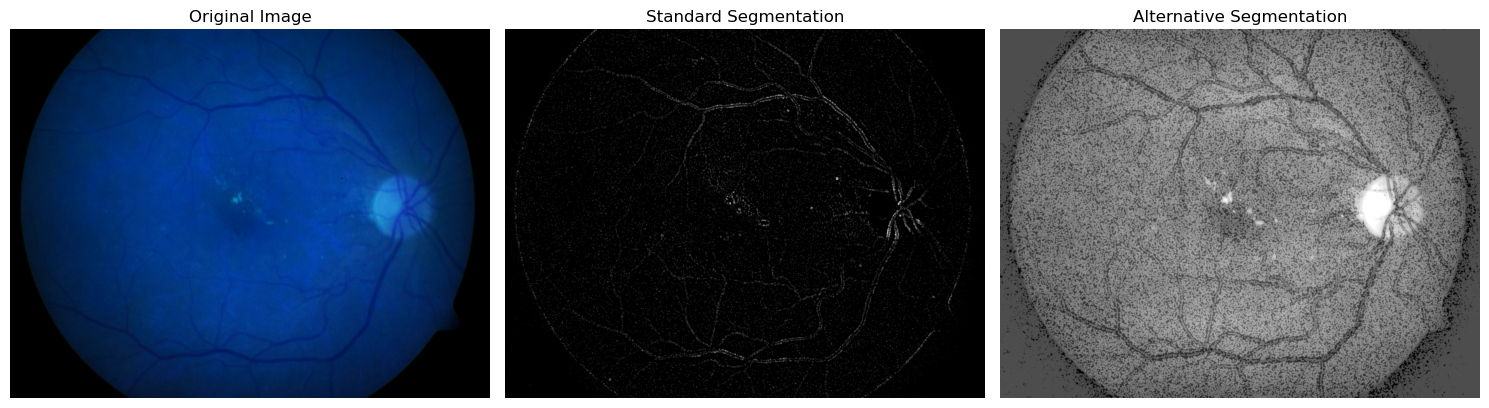

In [10]:
if len(image_files) > 0:
    # Process using the alternative method
    original, preprocessed, segmented_alt = process_image(sample_image_path, method="alternative")
    
    # Display the results
    if original is not None:
        # Convert original from BGR to RGB for display
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # Display the original, preprocessed, and segmented images
        display_multiple(
            [original_rgb, segmented, segmented_alt],
            titles=["Original Image", "Standard Segmentation", "Alternative Segmentation"],
            cmap=None
        )

Now, let's process all images in the input directory and save the results:

In [11]:
# Process all images using the standard method
print("Processing all images using the standard method...")
process_all_images(method="standard")

Processing all images using the standard method...
Processing image001.png...
Saved results for image001.png
Processing image002.png...
Saved results for image002.png
Processing image003.png...
Saved results for image003.png
Processing image004.png...
Saved results for image004.png
Processing image005.png...
Saved results for image005.png
Processing image006.png...
Saved results for image006.png
Processing image007.png...
Saved results for image007.png
Processing image008.png...
Saved results for image008.png
Processing image009.png...
Saved results for image009.png
Processing image010.png...
Saved results for image010.png
Processing image011.png...
Saved results for image011.png
Processing image012.png...
Saved results for image012.png
Processing image013.png...
Saved results for image013.png
Processing image014.png...
Saved results for image014.png
Processing image015.png...
Saved results for image015.png
Processing image016.png...
Saved results for image016.png
Processing image017.p

Let's also process all images using the alternative method for comparison:

In [12]:
# Process all images using the alternative method
print("Processing all images using the alternative method...")
process_all_images(method="alternative")

Processing all images using the alternative method...
Processing image001.png...
Saved results for image001.png
Processing image002.png...
Saved results for image002.png
Processing image003.png...
Saved results for image003.png
Processing image004.png...
Saved results for image004.png
Processing image005.png...
Saved results for image005.png
Processing image006.png...
Saved results for image006.png
Processing image007.png...
Saved results for image007.png
Processing image008.png...
Saved results for image008.png
Processing image009.png...
Saved results for image009.png
Processing image010.png...
Saved results for image010.png
Processing image011.png...
Saved results for image011.png
Processing image012.png...
Saved results for image012.png
Processing image013.png...
Saved results for image013.png
Processing image014.png...
Saved results for image014.png
Processing image015.png...
Saved results for image015.png
Processing image016.png...
Saved results for image016.png
Processing image01

## Conclusions

This notebook presents an algorithm for segmenting blood vessels from fundus images using standard image processing techniques and morphological operations. The segmentation pipeline consists of two main stages:

1. **Preprocessing**: We enhance the image features and reduce noise by:
   - Extracting the green channel (which provides the best vessel contrast)
   - Applying CLAHE for contrast enhancement
   - Using Gaussian blur for noise reduction
   - Applying morphological operations to enhance vessel structures

2. **Segmentation**: We extract and highlight the blood vessels by:
   - Applying edge detection using Sobel operators
   - Using adaptive thresholding to identify vessel candidates
   - Combining edge information with vessel candidates
   - Applying morphological operations to clean up the segmentation

We also implemented an alternative segmentation method using black-hat transform and different morphological operations for comparison.

### Observations

- The preprocessing stage is crucial for successful vessel segmentation, as it enhances the contrast between vessels and background.
- The standard segmentation method using edge detection and adaptive thresholding yields good results for vessel extraction.
- The alternative method using black-hat transform provides a different perspective, potentially capturing different vessel characteristics.

### Potential Improvements

- Fine-tuning of parameters (kernel sizes, thresholds, etc.) for specific datasets
- Implementation of more advanced vessel enhancement filters (e.g., proper Frangi filter)
- Incorporation of machine learning techniques for more accurate vessel segmentation
- Development of quantitative evaluation metrics if ground truth vessel masks are available

Overall, the algorithm provides a solid foundation for blood vessel segmentation from fundus images using standard image processing techniques, meeting the project requirements.

## Source Code

The complete source code for this project is presented in the cells above. The key components are:

1. **Directory Setup**: Creating and managing input/output directories
2. **Preprocessing**: Functions for enhancing image features and reducing noise
3. **Segmentation**: Two methods for extracting and highlighting blood vessels
4. **Image Processing Pipeline**: Functions for processing individual images and batches
5. **Visualization**: Functions for displaying and comparing results

The algorithm is designed to be modular, allowing for easy experimentation with different preprocessing and segmentation techniques. The output is maintained in grayscale format as per the project requirements, with higher intensity values highlighting the blood vessel structures.